In [21]:
from matplotlib.font_manager import fontManager
import os

fonts = [font.name for font in fontManager.ttflist if 
         os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 

for font in fonts:
    print(font)

Yu Gothic
Microsoft JhengHei
Malgun Gothic
Yu Gothic
KaiTi
Segoe UI Variable
STLiti
STXinwei
Yu Gothic
Segoe UI Symbol
Calibri
Nirmala UI
Calibri
Yu Gothic
STFangsong
Segoe UI Emoji
Microsoft JhengHei
SimSun-ExtB
Segoe UI Historic
DengXian
Cambria
STSong
LiSu
Microsoft YaHei
YouYuan
FZYaoTi
Gabriola
Calibri
Times New Roman
Malgun Gothic
MingLiU-ExtB
Microsoft JhengHei
Microsoft YaHei
DengXian
STXingkai
SimHei
Microsoft YaHei
STHupo
Times New Roman
STZhongsong
Nirmala UI
STKaiti
Arial
Nirmala UI
STXihei
Calibri
Calibri
STCaiyun
MS Gothic
FangSong
Malgun Gothic
Calibri
DengXian
FZShuTi
SimSun


In [1]:
import torch
import torch.nn as nn
import torchvision as tv
from torch.autograd import Variable
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False
from tqdm import tqdm

d:\Anaconda\envs\tf_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

batch_size = 512
noiseSize = 100     # 噪声维度
d_every = 1     # 每一个batch训练一次discriminator
g_every = 5     # 每五个batch训练一次generator
n_generator_feature = 64        # 生成器feature map数
n_discriminator_feature = 64        # 判别器feature map数

In [3]:
class NetGenerator(nn.Module):
    def __init__(self):
        super(NetGenerator,self).__init__()
        self.act1 = nn.ReLU(True)
        self.covt1 = nn.ConvTranspose2d(noiseSize, n_generator_feature * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(n_generator_feature * 8)
        self.covt2 = nn.ConvTranspose2d(n_generator_feature * 8, n_generator_feature * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(n_generator_feature * 4)
        self.covt3 = nn.ConvTranspose2d(n_generator_feature * 4, n_generator_feature * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(n_generator_feature * 2)
        self.covt4 = nn.ConvTranspose2d(n_generator_feature * 2, n_generator_feature, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(n_generator_feature)
        self.covt5 = nn.ConvTranspose2d(n_generator_feature, 3, kernel_size=5, stride=3, padding=1, bias=False)
        self.act2 = nn.Tanh()
        
    def forward(self, input):
        x = self.act1(self.bn1(self.covt1(input)))
        x = self.act1(self.bn2(self.covt2(x)))
        x = self.act1(self.bn3(self.covt3(x)))
        x = self.act1(self.bn4(self.covt4(x)))
        x = self.act2(self.covt5(x))
        return x

In [4]:
class NetDiscriminator(nn.Module):
    def __init__(self):
        super(NetDiscriminator,self).__init__()
        self.act1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(3, n_discriminator_feature, kernel_size=5, stride=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(n_discriminator_feature, n_discriminator_feature * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(n_discriminator_feature * 2)
        self.conv3 = nn.Conv2d(n_discriminator_feature * 2, n_discriminator_feature * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(n_discriminator_feature * 4)
        self.conv4 = nn.Conv2d(n_discriminator_feature * 4, n_discriminator_feature * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(n_discriminator_feature * 8)
        self.conv5 = nn.Conv2d(n_discriminator_feature * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)
        self.act2 = nn.Sigmoid() 
        
    def forward(self, input):
        x = self.act1(self.conv1(input))
        x = self.act1(self.bn2(self.conv2(x)))
        x = self.act1(self.bn3(self.conv3(x)))
        x = self.act1(self.bn4(self.conv4(x)))
        x = self.act2(self.conv5(x))
        return x.view(-1)

In [5]:
plot_epoch = [1,5,10,20,30,40,50,60,65,66]

In [6]:
class GAN():
    def __init__(self, Generator, Discriminator, batch_size, noiseSize, d_every, g_every, gpu=True):
        self.d = d_every
        self.g = g_every
        self.batch_size = batch_size
        self.noiseSize = noiseSize
        self.criterion = torch.nn.BCELoss()
        
        if gpu == True:
            if torch.cuda.is_available() == True:
                self.Generator = Generator.to('cuda')
                self.Discriminator = Discriminator.to('cuda')
                self.true_labels = Variable(torch.ones(batch_size)).to('cuda')     # batch_size
                self.fake_labels = Variable(torch.zeros(batch_size)).to('cuda')
                self.optimizer_g = torch.optim.Adam(self.Generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
                self.optimizer_d = torch.optim.Adam(self.Discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
                self.fix_noises = Variable(torch.randn(batch_size, noiseSize, 1, 1)).to('cuda')
                self.noises = Variable(torch.randn(batch_size, noiseSize, 1, 1)).to('cuda')     # 均值为0，方差为1的正态分布
            else:
                self.Generator = Generator
                self.Discriminator = Discriminator
                self.optimizer_g = torch.optim.Adam(self.Generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
                self.optimizer_d = torch.optim.Adam(self.Discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
                self.true_labels = Variable(torch.ones(batch_size))     
                self.fake_labels = Variable(torch.zeros(batch_size))
                self.fix_noises = Variable(torch.randn(batch_size, noiseSize, 1, 1))
                self.noises = Variable(torch.randn(batch_size, noiseSize, 1, 1))   
        else:
            self.Generator = Generator
            self.Discriminator = Discriminator
            self.optimizer_g = torch.optim.Adam(self.Generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
            self.optimizer_d = torch.optim.Adam(self.Discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
            self.true_labels = Variable(torch.ones(batch_size))     
            self.fake_labels = Variable(torch.zeros(batch_size))
            self.fix_noises = Variable(torch.randn(batch_size, noiseSize, 1, 1))
            self.noises = Variable(torch.randn(batch_size, noiseSize, 1, 1))     
        
        
    def train(self, dataloader):
        d_every = self.d
        g_every = self.g
        for i, (image,_) in tqdm(enumerate(dataloader)):       
            real_image = Variable(image)
            real_image = real_image.to('cuda')

            if (i + 1) % d_every == 0:
                self.optimizer_d.zero_grad()
                output = self.Discriminator(real_image)      
                error_d_real = self.criterion(output, self.true_labels)
                error_d_real.backward()

                self.noises.data.copy_(torch.randn(self.batch_size, self.noiseSize, 1, 1))
                fake_img = self.Generator(self.noises).detach()       
                fake_output = self.Discriminator(fake_img)       
                error_d_fake = self.criterion(fake_output, self.fake_labels)
                error_d_fake.backward()
                self.optimizer_d.step()

            if (i + 1) % g_every == 0:
                self.optimizer_g.zero_grad()
                self.noises.data.copy_(torch.randn(self.batch_size, self.noiseSize, 1, 1))
                fake_img = self.Generator(self.noises)        
                fake_output = self.Discriminator(fake_img)      
                error_g = self.criterion(fake_output, self.true_labels)
                error_g.backward()
                self.optimizer_g.step()
        
    def show(self, num):
        fix_fake_imags = self.Generator(self.fix_noises)
        fix_fake_imags = fix_fake_imags.data.cpu()[:64] * 0.5 + 0.5
        fig = plt.figure(1)

        i = 1
        for image in fix_fake_imags:
            ax = fig.add_subplot(8, 8, eval('%d' % i))
            plt.xticks([]), plt.yticks([])  # 去除坐标轴
            plt.axis('off')
            plt.imshow(image.permute(1, 2, 0))
            i += 1
        plt.subplots_adjust(left=None,  # the left side of the subplots of the figure
                            right=None,  # the right side of the subplots of the figure
                            bottom=None,  # the bottom of the subplots of the figure
                            top=None,  # the top of the subplots of the figure
                            wspace=0.05,  # the amount of width reserved for blank space between subplots
                            hspace=0.05)  # the amount of height reserved for white space between subplots)
        plt.suptitle('第%d迭代结果' % num, y=0.91, fontsize=15)
        plt.savefig('output'+str(num)+'.pdf')
        plt.show()

In [7]:
transform = tv.transforms.Compose([
    tv.transforms.Resize(96),     # 图片尺寸, transforms.Scale transform is deprecated
    tv.transforms.CenterCrop(96),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))       # 变成[-1,1]的数
])
path = r'C:\Users\20123\Desktop\计算机\深度学习\lab5\data'
dataset = tv.datasets.ImageFolder(path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
model = GAN(NetGenerator(), NetDiscriminator(), batch_size, noiseSize, d_every, g_every, True)


100it [00:20,  5.00it/s]


现在正在第 1 次迭代


100it [00:15,  6.52it/s]


现在正在第 2 次迭代


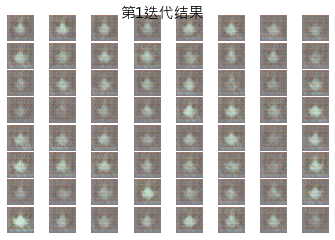

100it [00:15,  6.47it/s]


现在正在第 3 次迭代


100it [00:15,  6.48it/s]


现在正在第 4 次迭代


100it [00:15,  6.50it/s]


现在正在第 5 次迭代


100it [00:15,  6.51it/s]


现在正在第 6 次迭代


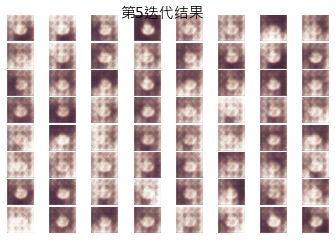

100it [00:15,  6.53it/s]


现在正在第 7 次迭代


100it [00:15,  6.54it/s]


现在正在第 8 次迭代


100it [00:15,  6.52it/s]


现在正在第 9 次迭代


100it [00:15,  6.49it/s]


现在正在第 10 次迭代


100it [00:15,  6.47it/s]


现在正在第 11 次迭代


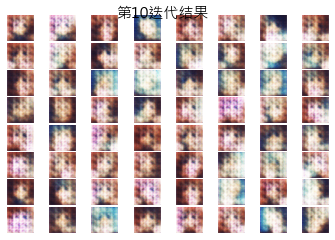

100it [00:15,  6.45it/s]


现在正在第 12 次迭代


100it [00:15,  6.53it/s]


现在正在第 13 次迭代


100it [00:15,  6.58it/s]


现在正在第 14 次迭代


100it [00:15,  6.57it/s]


现在正在第 15 次迭代


100it [00:15,  6.58it/s]


现在正在第 16 次迭代


100it [00:15,  6.57it/s]


现在正在第 17 次迭代


100it [00:15,  6.55it/s]


现在正在第 18 次迭代


100it [00:15,  6.57it/s]


现在正在第 19 次迭代


100it [00:15,  6.55it/s]


现在正在第 20 次迭代


100it [00:15,  6.57it/s]


现在正在第 21 次迭代


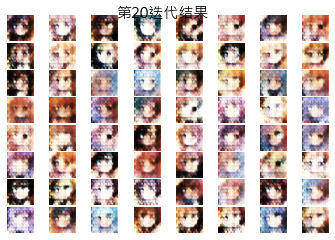

100it [00:15,  6.56it/s]


现在正在第 22 次迭代


100it [00:15,  6.56it/s]


现在正在第 23 次迭代


100it [00:15,  6.54it/s]


现在正在第 24 次迭代


100it [00:15,  6.58it/s]


现在正在第 25 次迭代


100it [00:15,  6.55it/s]


现在正在第 26 次迭代


100it [00:15,  6.54it/s]


现在正在第 27 次迭代


100it [00:15,  6.57it/s]


现在正在第 28 次迭代


100it [00:15,  6.55it/s]


现在正在第 29 次迭代


100it [00:15,  6.58it/s]


现在正在第 30 次迭代


100it [00:15,  6.55it/s]


现在正在第 31 次迭代


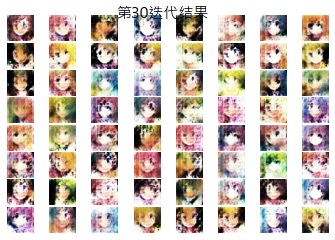

100it [00:15,  6.55it/s]


现在正在第 32 次迭代


100it [00:15,  6.56it/s]


现在正在第 33 次迭代


100it [00:15,  6.60it/s]


现在正在第 34 次迭代


100it [00:15,  6.56it/s]


现在正在第 35 次迭代


100it [00:15,  6.58it/s]


现在正在第 36 次迭代


100it [00:15,  6.56it/s]


现在正在第 37 次迭代


100it [00:15,  6.56it/s]


现在正在第 38 次迭代


100it [00:15,  6.56it/s]


现在正在第 39 次迭代


100it [00:15,  6.56it/s]


现在正在第 40 次迭代


100it [00:15,  6.44it/s]


现在正在第 41 次迭代


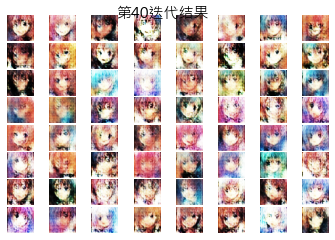

100it [00:15,  6.34it/s]


现在正在第 42 次迭代


100it [00:15,  6.40it/s]


现在正在第 43 次迭代


100it [00:15,  6.44it/s]


现在正在第 44 次迭代


100it [00:15,  6.34it/s]


现在正在第 45 次迭代


100it [00:15,  6.41it/s]


现在正在第 46 次迭代


100it [00:15,  6.43it/s]


现在正在第 47 次迭代


100it [00:15,  6.45it/s]


现在正在第 48 次迭代


100it [00:15,  6.40it/s]


现在正在第 49 次迭代


100it [00:15,  6.42it/s]


现在正在第 50 次迭代


100it [00:15,  6.40it/s]


现在正在第 51 次迭代


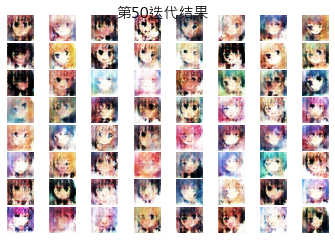

100it [00:15,  6.40it/s]


现在正在第 52 次迭代


100it [00:15,  6.42it/s]


现在正在第 53 次迭代


100it [00:15,  6.41it/s]


现在正在第 54 次迭代


100it [00:15,  6.43it/s]


现在正在第 55 次迭代


100it [00:15,  6.46it/s]


现在正在第 56 次迭代


100it [00:15,  6.47it/s]


现在正在第 57 次迭代


100it [00:15,  6.43it/s]


现在正在第 58 次迭代


100it [00:15,  6.46it/s]


现在正在第 59 次迭代


100it [00:15,  6.46it/s]


现在正在第 60 次迭代


100it [00:15,  6.44it/s]


现在正在第 61 次迭代


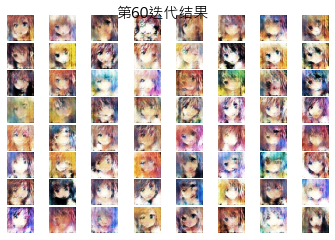

100it [00:15,  6.45it/s]


现在正在第 62 次迭代


100it [00:15,  6.45it/s]


现在正在第 63 次迭代


100it [00:15,  6.44it/s]


现在正在第 64 次迭代


100it [00:15,  6.45it/s]


现在正在第 65 次迭代


100it [00:15,  6.42it/s]


现在正在第 66 次迭代


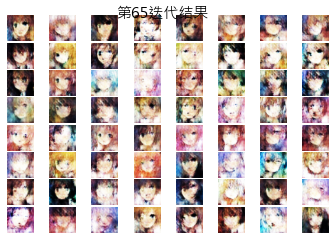

In [8]:
for i in range(66):        # 最大迭代次数
    model.train(dataloader)
    print('现在正在第 {} 次迭代'.format(i+1))
    if i in plot_epoch:
        model.show(i)

100it [00:15,  6.42it/s]


现在正在第 67 次迭代


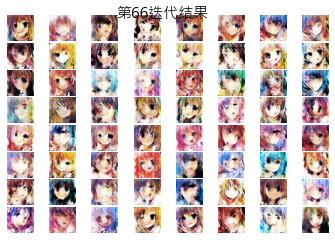

In [9]:
i += 1
model.train(dataloader)
print('现在正在第 {} 次迭代'.format(i+1))
if i in plot_epoch:
    model.show(i)